In [24]:
# Library importations
import yfinance as yf # For downloading financial data
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from scipy import stats
import matplotlib.pyplot as plt
import datetime # Used for annualizing returns

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Data Extraction with yfinance

We'll download historical stock prices for our 3 stocks using the `yfinance` library.

**Key yfinance concepts:**
- `yf.Ticker(symbol)` creates a ticker object
- `.history(start, end)` downloads historical price data
- Data includes: Open, High, Low, Close, Volume

In [ ]:
# Define portfolio parameters
Tickers = ['GOOG', 'MSFT', 'NVDA', 'PLTR']  # Asset tickers: Google, Microsoft, NVIDIA, Palantir
n = len(Tickers)  # Number of assets
r0 = 0.03  # Risk-free rate (3% annual)

# Define data download period
startinput = '2020-09-30'
endinput = '2025-10-01'

# Download data for the period 2022-2024
data = pd.Series(dtype=object)
for ticker in Tickers:
    print(f"Downloading {ticker}...")
    data[ticker] = yf.Ticker(ticker).history(start=startinput, end=endinput)
    
print(f"\nData downloaded successfully for {n} stocks!")


Data downloaded successfully for 4 stocks!


## 2. Data Exploration

Let's examine the downloaded data structure and visualize the closing prices.

Number of observations per stock:
GOOG: 1256 days
MSFT: 1256 days
NVDA: 1256 days
PLTR: 1256 days


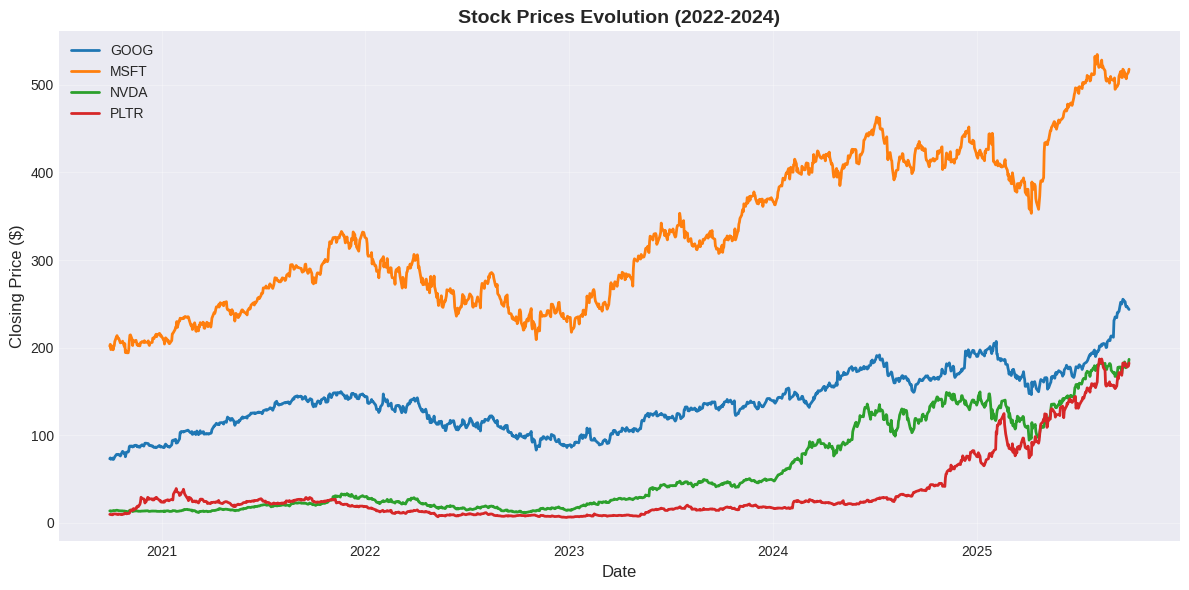


Sample data for GOOG:
                                Open       High        Low      Close  \
Date                                                                    
2020-09-30 00:00:00-04:00  72.841520  73.981227  72.497879  72.980576   
2020-10-01 00:00:00-04:00  73.709093  74.442576  73.457814  73.998116   
2020-10-02 00:00:00-04:00  72.604646  73.655954  72.052918  72.425369   
2020-10-05 00:00:00-04:00  72.812236  73.904758  72.715895  73.796005   
2020-10-06 00:00:00-04:00  73.277541  73.832739  71.937210  72.178062   

                             Volume  Dividends  Stock Splits  
Date                                                          
2020-09-30 00:00:00-04:00  34032000        0.0           0.0  
2020-10-01 00:00:00-04:00  35590000        0.0           0.0  
2020-10-02 00:00:00-04:00  25682000        0.0           0.0  
2020-10-05 00:00:00-04:00  22266000        0.0           0.0  
2020-10-06 00:00:00-04:00  24908000        0.0           0.0  


In [12]:
# Display basic information
print("Number of observations per stock:")
for ticker in Tickers:
    print(f"{ticker}: {len(data[ticker])} days")

# Visualize closing prices
fig, ax = plt.subplots(figsize=(12, 6))
for ticker in Tickers:
    ax.plot(data[ticker].index, data[ticker]['Close'], label=ticker, linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price ($)', fontsize=12)
ax.set_title('Stock Prices Evolution (2022-2024)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display sample data
print("\nSample data for GOOG:")
print(data['GOOG'].head())

## 3. Returns Calculation

Calculate **daily simple returns**: $R_t = \frac{P_t}{P_{t-1}} - 1$

Where:
- $P_t$ = closing price at time $t$
- $P_{t-1}$ = closing price at time $t-1$

Daily Returns Statistics:
              GOOG         MSFT         NVDA         PLTR
count  1255.000000  1255.000000  1255.000000  1255.000000
mean      0.001150     0.000886     0.002631     0.003349
std       0.019460     0.016406     0.032920     0.045163
min      -0.096350    -0.077156    -0.169682    -0.213080
25%      -0.009238    -0.007408    -0.015774    -0.020151
50%       0.001860     0.000763     0.002970     0.000528
75%       0.011339     0.010036     0.021178     0.023158
max       0.099652     0.101337     0.243696     0.308014


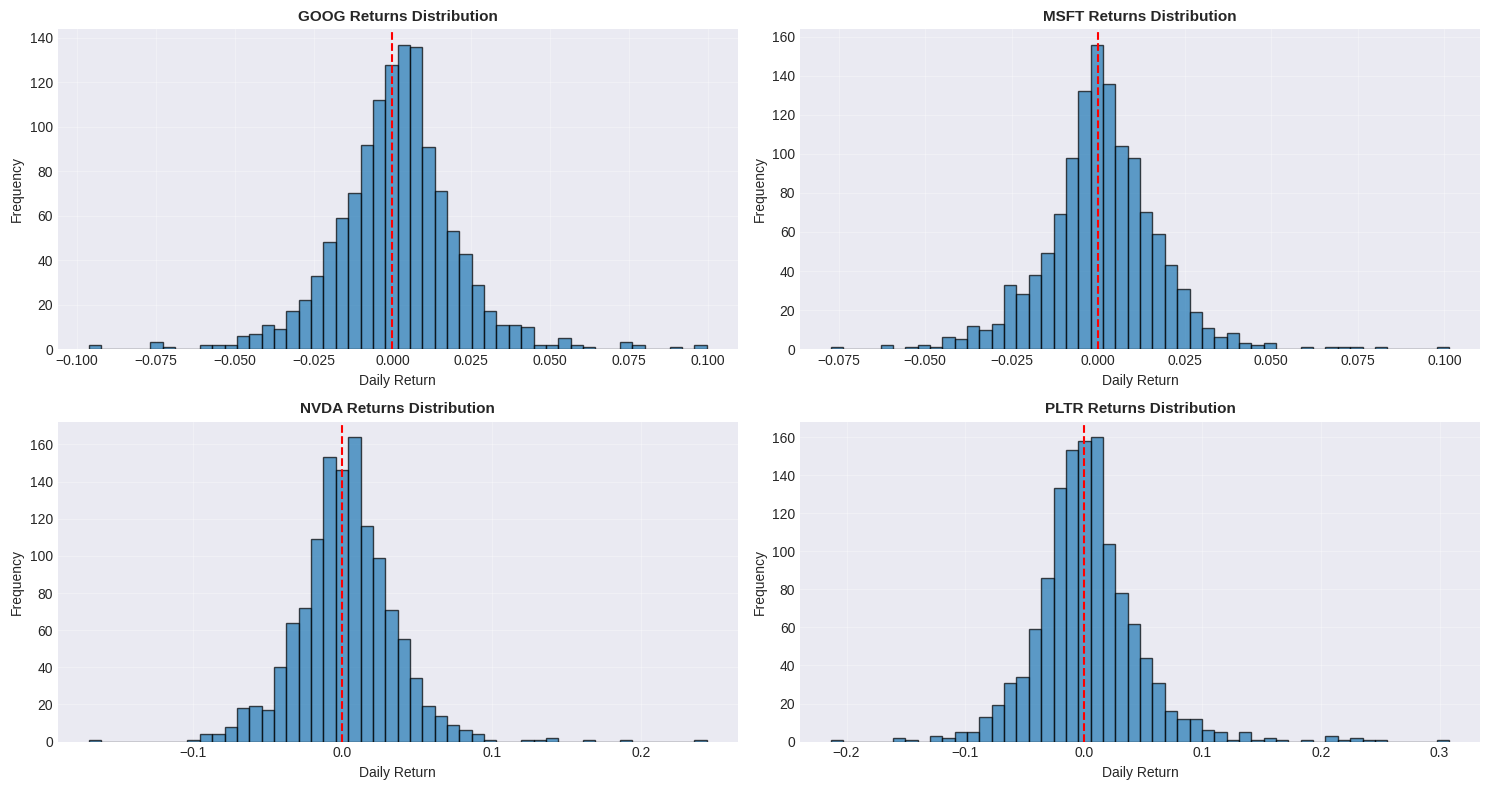

In [14]:
# Calculate daily returns for each stock
data_R = pd.DataFrame()

for ticker in Tickers:
    # Calculate returns: R_t = P_t / P_{t-1} - 1
    data_R[ticker] = (data[ticker]['Close'] / data[ticker]['Close'].shift(1) - 1)

# Remove NaN values (first row)
data_R = data_R.dropna()

print("Daily Returns Statistics:")
print(data_R.describe())

# Visualize returns distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
for i, ticker in enumerate(Tickers):
    axes[i // 2, i % 2].hist(data_R[ticker], bins=50, edgecolor='black', alpha=0.7)
    axes[i // 2, i % 2].set_xlabel('Daily Return', fontsize=10)
    axes[i // 2, i % 2].set_ylabel('Frequency', fontsize=10)
    axes[i // 2, i % 2].set_title(f'{ticker} Returns Distribution', fontsize=11, fontweight='bold')
    axes[i // 2, i % 2].grid(True, alpha=0.3)
    axes[i // 2, i % 2].axvline(x=0, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

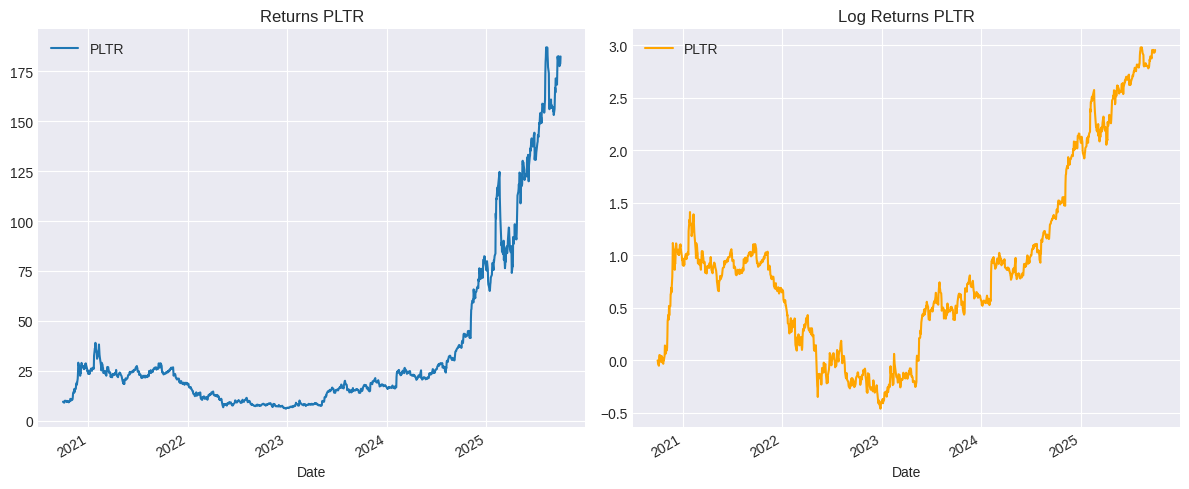

In [16]:
# Daily Returns and Log Returns for PLTR
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Returns 
returns = data['PLTR']['Close'].dropna()
returns.plot(ax=axes[0], label='PLTR')
axes[0].set_title('Returns PLTR')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Log Returns
log_returns = np.log(data['PLTR']['Close'] / data['PLTR']['Close'].iloc[0])
log_returns.plot(ax=axes[1], label='PLTR', color='orange')
axes[1].set_title('Log Returns PLTR')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Annualization of Returns and Volatilities

What is annualization?

Annualization is the process of converting periodic returns and volatilities (e.g., daily, monthly) into annual figures. Conceptually, it means to determine what the return or volatility would be if the investment period were extended to one year given the observed periodic data.

There are 2 ways to annualize returns and volatilities:

### 1. Using the average length of a trading period in years (delta)
**Annualization formulas:**
- **Mean return (M)**: $M_{\text{annual}} = \frac{E[R_{\text{daily}}]}{\delta}$
- **Variance ($\Sigma$)**: $\Sigma_{\text{annual}} = \frac{\Sigma_{\text{daily}}}{\delta}$
- **Standard deviation ($\sigma$)**: $\sigma_{\text{annual}} = \frac{\sigma_{\text{daily}}}{\sqrt{\delta}}$

### 2. Using the annualization factor (AFactor)

**Annualization formulas:**
- **Mean return (M)**: $M_{\text{annual}} = \text{AFactor} \times E[R_{\text{daily}}]$
- **Variance ($\Sigma$)**: $\Sigma_{\text{annual}} = \text{AFactor} \times \Sigma_{\text{daily}}$
- **Standard deviation ($\sigma$)**: $\sigma_{\text{annual}} = \sqrt{\text{AFactor}} \times \sigma_{\text{daily}}$

Where **AFactor** (annualization factor) = number of trading days in a year ≈ 252

In [34]:
S = pd.DataFrame() # DataFrame to hold closing prices
for t in Tickers:
    S[t] = data[t]['Close']

# daily price returns
R = S / S.shift(1) - 1  # calculate the returns
R = R[1:]               # eliminate the first row which is undefined
Mean_d = R.mean()
Covar_d = R.cov()
Corr = R.corr()

Ys = int(startinput[0:4])
Ms = int(startinput[5:7])
Ds = int(startinput[8:10])
Ye = int(endinput[0:4])
Me = int(endinput[5:7])
De = int(endinput[8:10])

startdate = datetime.date(Ys, Ms, Ds)
enddate = datetime.date(Ye, Me, De)
z = enddate - startdate
Duration = float(z.days)
m = float(len(R))                       # number of periods
delta = Duration / 365 / m              # average length of each trading period in years

Sigma = Covar_d / delta                 # cov matrix on annualised basis
STD = np.sqrt(np.diag(Sigma))
Mean = Mean_d / delta
Corr = R.corr()

print("\nMean:")
print(Mean)
print("\nStandard deviation:")
print(STD)
print("\nVariance Covariance:")
print(Sigma)
print("\nCorrelation:")
print(Corr)


Mean:
GOOG    0.288273
MSFT    0.222154
NVDA    0.659751
PLTR    0.839587
dtype: float64

Standard deviation:
[0.30813511 0.25977437 0.52126795 0.71511856]

Variance Covariance:
          GOOG      MSFT      NVDA      PLTR
GOOG  0.094947  0.053632  0.085316  0.074311
MSFT  0.053632  0.067483  0.086148  0.071136
NVDA  0.085316  0.086148  0.271720  0.164209
PLTR  0.074311  0.071136  0.164209  0.511395

Correlation:
          GOOG      MSFT      NVDA      PLTR
GOOG  1.000000  0.670014  0.531162  0.337235
MSFT  0.670014  1.000000  0.636188  0.382928
NVDA  0.531162  0.636188  1.000000  0.440513
PLTR  0.337235  0.382928  0.440513  1.000000


In [35]:
# Calculate annualization factor
AFactor = (m / Duration) * 365  # Standard number of trading days per year

# Calculate annualized mean returns vector M
M = AFactor * data_R.mean()
M = M.values  # Convert to numpy array

# Calculate annualized covariance matrix Sigma
Sigma = AFactor * data_R.cov()
Sigma = Sigma.values  # Convert to numpy array

# Calculate annualized standard deviations (volatilities)
STD = np.sqrt(np.diag(Sigma))

# Display results
print("=" * 60)
print("ANNUALIZED STATISTICS (using AFactor = 252)")
print("=" * 60)
print("\nAnnualized Expected Returns (M):")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {M[i]:.4f} ({M[i]*100:.2f}%)")

print("\nAnnualized Volatilities (σ):")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {STD[i]:.4f} ({STD[i]*100:.2f}%)")

print("\nAnnualized Covariance Matrix (Σ):")
print(pd.DataFrame(Sigma, index=Tickers, columns=Tickers).round(4))

ANNUALIZED STATISTICS (using AFactor = 252)

Annualized Expected Returns (M):
  GOOG: 0.2883 (28.83%)
  MSFT: 0.2222 (22.22%)
  NVDA: 0.6598 (65.98%)
  PLTR: 0.8396 (83.96%)

Annualized Volatilities (σ):
  GOOG: 0.3081 (30.81%)
  MSFT: 0.2598 (25.98%)
  NVDA: 0.5213 (52.13%)
  PLTR: 0.7151 (71.51%)

Annualized Covariance Matrix (Σ):
        GOOG    MSFT    NVDA    PLTR
GOOG  0.0949  0.0536  0.0853  0.0743
MSFT  0.0536  0.0675  0.0861  0.0711
NVDA  0.0853  0.0861  0.2717  0.1642
PLTR  0.0743  0.0711  0.1642  0.5114


## 5. Correlation Analysis

The correlation matrix shows how stocks move together:
- Correlation = 1: Perfect positive correlation
- Correlation = 0: No correlation
- Correlation = -1: Perfect negative correlation

**Diversification benefit**: Lower correlations provide better risk reduction.

Correlation Matrix:
        GOOG    MSFT    NVDA    PLTR
GOOG  1.0000  0.6700  0.5312  0.3372
MSFT  0.6700  1.0000  0.6362  0.3829
NVDA  0.5312  0.6362  1.0000  0.4405
PLTR  0.3372  0.3829  0.4405  1.0000


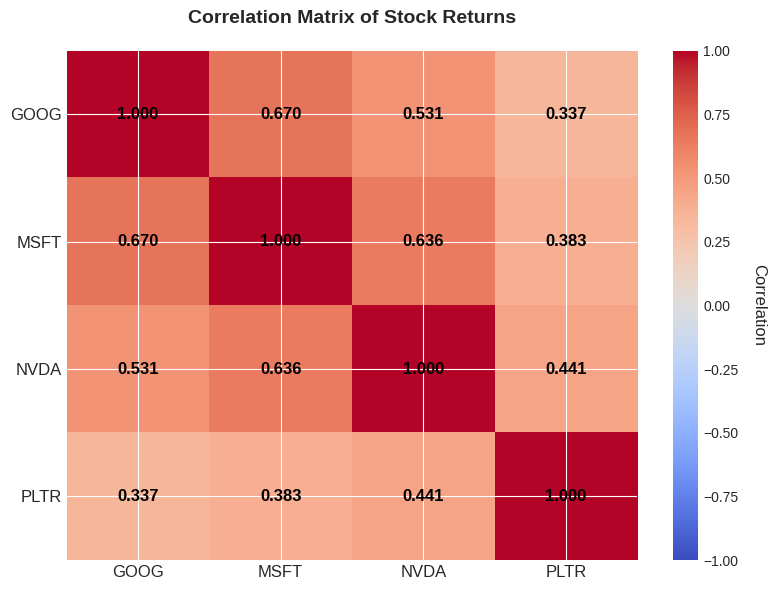

In [36]:
# Calculate correlation matrix
Corr = data_R.corr()

print("Correlation Matrix:")
print(Corr.round(4))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(Corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(Tickers, fontsize=12)
ax.set_yticklabels(Tickers, fontsize=12)

# Add correlation values
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f'{Corr.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20, fontsize=12)

ax.set_title('Correlation Matrix of Stock Returns', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 6. Markowitz Framework - Without Risk-Free Asset

Following the notation from our reference document, we calculate:

**Key parameters:**
- $a = 1_n' \Sigma^{-1} 1_n$ (scalar product)
- $b = M' \Sigma^{-1} 1_n$ (scalar product)

**Minimum Variance Portfolio** ($\pi_a$):
$$\pi_a = \frac{1}{a}\Sigma^{-1}1_n$$

Properties:
- Expected return: $m_{\pi_a} = \frac{b}{a}$
- Volatility: $\sigma_{\pi_a} = \frac{1}{\sqrt{a}}$

In [37]:
# Create vector of ones (1_n)
Vec1 = np.ones(n)

# Calculate inverse of Sigma
InvSigma = inv(Sigma)

# Calculate key parameters a and b
a = Vec1.T @ InvSigma @ Vec1  # a = 1_n' Sigma^{-1} 1_n
b = M.T @ InvSigma @ Vec1      # b = M' Sigma^{-1} 1_n

print("=" * 60)
print("KEY PARAMETERS (Markowitz Framework)")
print("=" * 60)
print(f"a = 1_n' Σ^(-1) 1_n = {a:.6f}")
print(f"b = M' Σ^(-1) 1_n = {b:.6f}")

# Calculate minimum variance portfolio π_a
pi_a = (1/a) * InvSigma @ Vec1

# Properties of minimum variance portfolio
m_a = b / a  # Expected return
sigma_a = 1 / math.sqrt(a)  # Volatility

print("\n" + "=" * 60)
print("MINIMUM VARIANCE PORTFOLIO (π_a)")
print("=" * 60)
print("\nWeights:")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {pi_a[i]:.4f} ({pi_a[i]*100:.2f}%)")
print(f"\nSum of weights: {pi_a.sum():.4f}")

print(f"\nExpected return (m_a): {m_a:.4f} ({m_a*100:.2f}%)")
print(f"Volatility (σ_a): {sigma_a:.4f} ({sigma_a*100:.2f}%)")
print(f"Sharpe Ratio: {(m_a - r0)/sigma_a:.4f}")

KEY PARAMETERS (Markowitz Framework)
a = 1_n' Σ^(-1) 1_n = 16.376500
b = M' Σ^(-1) 1_n = 3.010168

MINIMUM VARIANCE PORTFOLIO (π_a)

Weights:
  GOOG: 0.2819 (28.19%)
  MSFT: 0.8499 (84.99%)
  NVDA: -0.1355 (-13.55%)
  PLTR: 0.0037 (0.37%)

Sum of weights: 1.0000

Expected return (m_a): 0.1838 (18.38%)
Volatility (σ_a): 0.2471 (24.71%)
Sharpe Ratio: 0.6224


## 7. Tangent Portfolio - With Risk-Free Asset

When a risk-free asset with return $r_0$ is available, the optimal risky portfolio is the **Tangent Portfolio** ($\pi_T$):

$$\pi_T = \frac{1}{b - r_0 a}\Sigma^{-1}(M - r_0 1_n)$$

This portfolio:
- Has the **maximum Sharpe ratio** among all risky portfolios
- Lies on the **Capital Market Line (CML)**
- Is the optimal combination of risky assets for all investors (Two-Fund Separation)

In [38]:
# Calculate Tangent Portfolio π_T
pi_T = (1 / (b - r0 * a)) * InvSigma @ (M - r0 * Vec1)

# Properties of tangent portfolio
m_T = pi_T @ M  # Expected return
sigma_T = math.sqrt(pi_T @ Sigma @ pi_T)  # Volatility
SR_T = (m_T - r0) / sigma_T  # Sharpe Ratio

print("=" * 60)
print("TANGENT PORTFOLIO (π_T)")
print("=" * 60)
print("\nWeights in risky assets:")
for i, ticker in enumerate(Tickers):
    print(f"  {ticker}: {pi_T[i]:.4f} ({pi_T[i]*100:.2f}%)")
print(f"\nSum of weights: {pi_T.sum():.4f}")

print(f"\nExpected return (m_T): {m_T:.4f} ({m_T*100:.2f}%)")
print(f"Volatility (σ_T): {sigma_T:.4f} ({sigma_T*100:.2f}%)")
print(f"Sharpe Ratio (SR_T): {SR_T:.4f}")

print("\n" + "-" * 60)
print("COMPARISON: Minimum Variance vs Tangent Portfolio")
print("-" * 60)
print(f"{'Metric':<25} {'Min Var (π_a)':<20} {'Tangent (π_T)':<20}")
print("-" * 60)
print(f"{'Expected Return':<25} {m_a*100:>18.2f}% {m_T*100:>18.2f}%")
print(f"{'Volatility':<25} {sigma_a*100:>18.2f}% {sigma_T*100:>18.2f}%")
print(f"{'Sharpe Ratio':<25} {(m_a-r0)/sigma_a:>18.4f} {SR_T:>18.4f}")

TANGENT PORTFOLIO (π_T)

Weights in risky assets:
  GOOG: 0.4311 (43.11%)
  MSFT: -0.5566 (-55.66%)
  NVDA: 0.7103 (71.03%)
  PLTR: 0.4152 (41.52%)

Sum of weights: 1.0000

Expected return (m_T): 0.8178 (81.78%)
Volatility (σ_T): 0.5593 (55.93%)
Sharpe Ratio (SR_T): 1.4087

------------------------------------------------------------
COMPARISON: Minimum Variance vs Tangent Portfolio
------------------------------------------------------------
Metric                    Min Var (π_a)        Tangent (π_T)       
------------------------------------------------------------
Expected Return                        18.38%              81.78%
Volatility                             24.71%              55.93%
Sharpe Ratio                          0.6224             1.4087


## 8. Efficient Frontier and Capital Market Line Visualization

The **Efficient Frontier** $\mathcal{F}$ is a hyperbola in $(σ, m)$ space representing all efficient portfolios.

The **Capital Market Line (CML)** $\mathcal{C}$ is a straight line from $(0, r_0)$ tangent to $\mathcal{F}$ at the tangent portfolio.

For the frontier, we use:
$$\sigma^2 = \left(\frac{m - m_a}{m_w}\right)^2 + \sigma_a^2$$

where $m_w = \|M - \frac{b}{a}1_n\|_{\Sigma^{-1}}$

check mean equality: 0.18381019383997194 0.183810193839972
check var equality: 0.24710950535924495 0.24710950535924497


/tmp/ipykernel_490795/1835193046.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[0], (STD[0], Mean[0]))
/tmp/ipykernel_490795/1835193046.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[1], (STD[1], Mean[1]))
/tmp/ipykernel_490795/1835193046.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(Tickers[2], (STD[2], Mean[2]))
/tmp/ipykernel_490795/1835193046.py:67: FutureWar

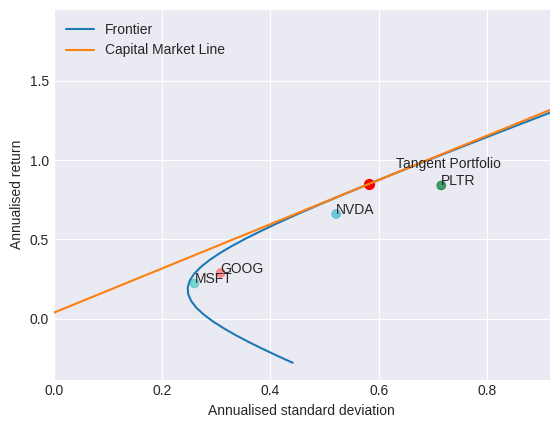

In [48]:
from numpy.linalg import inv
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

r = 0.0375  # risk-free rate
d = len(Tickers)
Vec1 = np.linspace(1, 1, d)
InvSigma = inv(Sigma)

# Important variables calculation
a = Vec1.T.dot(InvSigma).dot(Vec1)
b = Mean.T.dot(InvSigma).dot(Vec1)

# Portfolio of minimal variance
pi_a = InvSigma.dot(Vec1) / a
sd_a = 1 / np.sqrt(a)
m_a = b / a

print("check mean equality:", m_a, pi_a.T.dot(Mean))
print("check var equality:", sd_a, np.sqrt(pi_a.T.dot(Sigma).dot(pi_a)))

# Self financing Portfolio
m_w = np.sqrt((Mean - b / a * Vec1).T.dot(InvSigma).dot(Mean - b / a * Vec1))  # expected excess return

# Tangent Portfolio
pi_T = InvSigma.dot(Mean - r * Vec1) / (b - r * a)
sd_T = np.sqrt(pi_T.T.dot(Sigma).dot(pi_T))
m_T = pi_T.T.dot(Mean)

# Graph plot
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', "#027E33"]

range_inf = np.min(Mean) - 0.5
range_sup = np.max(Mean) + 1
y = np.linspace(range_inf, range_sup, 50)
x_1 = pd.DataFrame()  # sigma Frontier
x_2 = pd.DataFrame()  # sigma CML

i = 0
for i in range(len(y)):  # values of m
    x_1[i] = [np.sqrt(((y[i] - m_a) ** 2 / m_w ** 2) + sd_a ** 2)]  # Frontier
    x_2[i] = [(y[i] - r) / (m_T - r) * sd_T]  # Capital Market Line

xf_1 = x_1.iloc[0]
xc_1 = x_2.iloc[0]

range_inf_x = 0
range_sup_x = np.max(STD) + 0.2
plt.xlim(range_inf_x, range_sup_x)

plt.plot(xf_1, y, alpha=1, label='Frontier')
plt.plot(xc_1, y, alpha=1, label='Capital Market Line')
plt.legend(['Frontier', 'Capital Market Line'], loc=2)

plt.scatter(STD, Mean, c=colors, alpha=0.7)  # plot the assets
plt.grid(True)
plt.xlabel('Annualised standard deviation')
plt.ylabel('Annualised return')

plt.scatter(sd_T, m_T, color='red', s=50, alpha=1)  # Tangent portfolio point
ax.annotate('Tangent Portfolio', (sd_T + 0.05, m_T + 0.10))

ax.annotate(Tickers[0], (STD[0], Mean[0]))
ax.annotate(Tickers[1], (STD[1], Mean[1]))
ax.annotate(Tickers[2], (STD[2], Mean[2]))
ax.annotate(Tickers[3], (STD[3], Mean[3]))

plt.show()

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_490795/2704980053.py:27: SyntaxWarning: invalid escape sequence '\p'
  edgecolor='black', linewidth=2, zorder=5, label='Min Variance Portfolio ($\pi_a$)')
/tmp/ipykernel_490795/2704980053.py:31: SyntaxWarning: invalid escape sequence '\p'
  edgecolor='black', linewidth=2, zorder=5, label='Tangent Portfolio ($\pi_T$)')
/tmp/ipykernel_490795/2704980053.py:35: SyntaxWarning: invalid escape sequence '\m'
  label='Efficient Frontier $\mathcal{F}$', alpha=0.8)
/tmp/ipykernel_490795/2704980053.py:39: SyntaxWarning: invalid escape sequence '\m'
  label='Capital Market Line $\mat

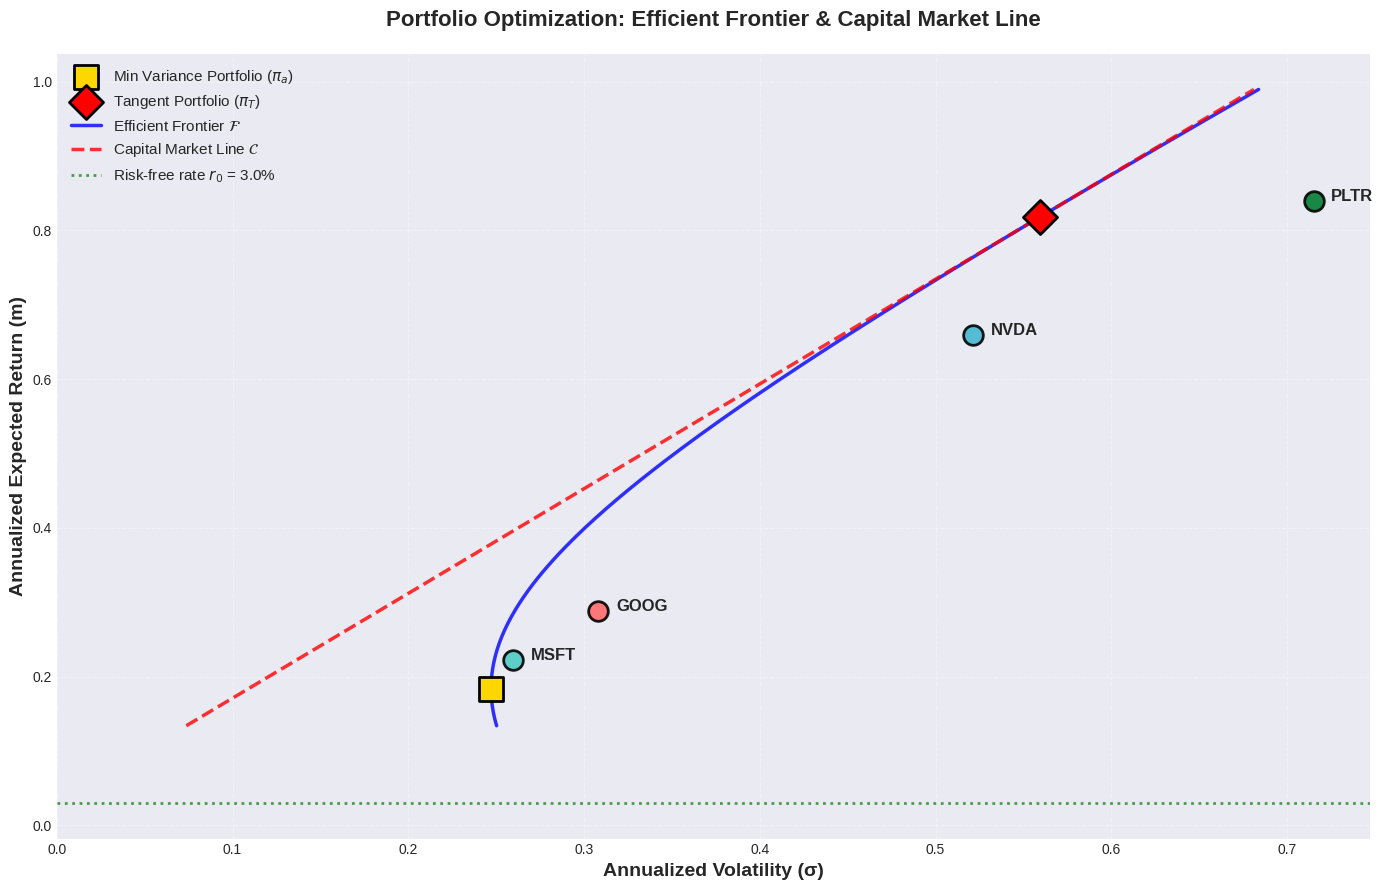

Chart displays:
  • Individual assets (GOOG, MSFT, NVDA, PLTR)
  • Minimum Variance Portfolio (π_a) - lowest risk
  • Tangent Portfolio (π_T) - maximum Sharpe ratio
  • Efficient Frontier - all efficient portfolios without risk-free asset
  • Capital Market Line - optimal combinations with risk-free asset


In [41]:
# Calculate m_w for the efficient frontier equation
m_w = math.sqrt((M - (b/a) * Vec1).T @ InvSigma @ (M - (b/a) * Vec1))

# Generate range of expected returns for plotting
range_inf = min(M.min(), m_a) - 0.05
range_sup = max(M.max(), m_T) + 0.15
m_range = np.linspace(range_inf, range_sup, 200)

# Calculate Efficient Frontier (hyperbola)
sigma_frontier = np.sqrt(((m_range - m_a) / m_w)**2 + sigma_a**2)

# Calculate Capital Market Line (straight line from r0 through π_T)
sigma_CML = (m_range - r0) / SR_T

# Create the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Plot individual assets
colors_assets = ['#FF6B6B', '#4ECDC4', '#45B7D1', "#027E33"]  
for i, ticker in enumerate(Tickers):
    ax.scatter(STD[i], M[i], s=200, c=colors_assets[i], 
              edgecolor='black', linewidth=2, zorder=5, alpha=0.9)
    ax.annotate(ticker, (STD[i] + 0.01, M[i]), fontsize=12, fontweight='bold')

# Plot minimum variance portfolio
ax.scatter(sigma_a, m_a, s=300, c='gold', marker='s', 
          edgecolor='black', linewidth=2, zorder=5, label='Min Variance Portfolio ($\pi_a$)')

# Plot tangent portfolio
ax.scatter(sigma_T, m_T, s=300, c='red', marker='D', 
          edgecolor='black', linewidth=2, zorder=5, label='Tangent Portfolio ($\pi_T$)')

# Plot Efficient Frontier
ax.plot(sigma_frontier, m_range, 'b-', linewidth=2.5, 
       label='Efficient Frontier $\mathcal{F}$', alpha=0.8)

# Plot Capital Market Line
ax.plot(sigma_CML, m_range, 'r--', linewidth=2.5, 
       label='Capital Market Line $\mathcal{C}$', alpha=0.8)

# Plot risk-free rate
ax.axhline(y=r0, color='green', linestyle=':', linewidth=2, 
          label=f'Risk-free rate $r_0$ = {r0*100:.1f}%', alpha=0.7)

# Formatting
ax.set_xlabel('Annualized Volatility (σ)', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Expected Return (m)', fontsize=14, fontweight='bold')
ax.set_title('Portfolio Optimization: Efficient Frontier & Capital Market Line', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

print("Chart displays:")
print("  • Individual assets (GOOG, MSFT, NVDA, PLTR)")
print("  • Minimum Variance Portfolio (π_a) - lowest risk")
print("  • Tangent Portfolio (π_T) - maximum Sharpe ratio")
print("  • Efficient Frontier - all efficient portfolios without risk-free asset")
print("  • Capital Market Line - optimal combinations with risk-free asset")

## 9. Performance Indicators and Risk Decomposition

For each asset, we calculate:

**1. Beta relative to Tangent Portfolio:**
$$\beta_T(i) = \frac{Cov(R_T, R_i)}{Var(R_T)} = \frac{\sigma_{T,i}}{\sigma_T^2}$$

**2. Sharpe Ratio:**
$$SR_i = \frac{m_i - r_0}{\sigma_i}$$

**3. Jensen Index (excess return above SML):**
$$JI_i = m_i - [r_0 + \beta_T(i)(m_T - r_0)]$$

**4. Risk Decomposition:**
- Systematic risk: $\sigma_T |\beta_T(i)|$
- Idiosyncratic risk: $\sigma_\epsilon = \sqrt{\sigma_i^2 - \sigma_T^2 \beta_T(i)^2}$

PERFORMANCE INDICATORS FOR INDIVIDUAL ASSETS

GOOG:
----------------------------------------
  Expected Return:      0.2883 (28.83%)
  Volatility:           0.3081 (30.81%)
  Sharpe Ratio:         0.8382
  Beta (β_T):           0.3278
  Jensen Index (α):     -0.0000 (-0.00%)
  Systematic Risk:      0.1833 (18.33%)
  Idiosyncratic Risk:   0.2477 (24.77%)
  Total Risk Check:     0.3081

MSFT:
----------------------------------------
  Expected Return:      0.2222 (22.22%)
  Volatility:           0.2598 (25.98%)
  Sharpe Ratio:         0.7397
  Beta (β_T):           0.2439
  Jensen Index (α):     -0.0000 (-0.00%)
  Systematic Risk:      0.1364 (13.64%)
  Idiosyncratic Risk:   0.2211 (22.11%)
  Total Risk Check:     0.2598

NVDA:
----------------------------------------
  Expected Return:      0.6598 (65.98%)
  Volatility:           0.5213 (52.13%)
  Sharpe Ratio:         1.2081
  Beta (β_T):           0.7993
  Jensen Index (α):     -0.0000 (-0.00%)
  Systematic Risk:      0.4470 (44.70%)


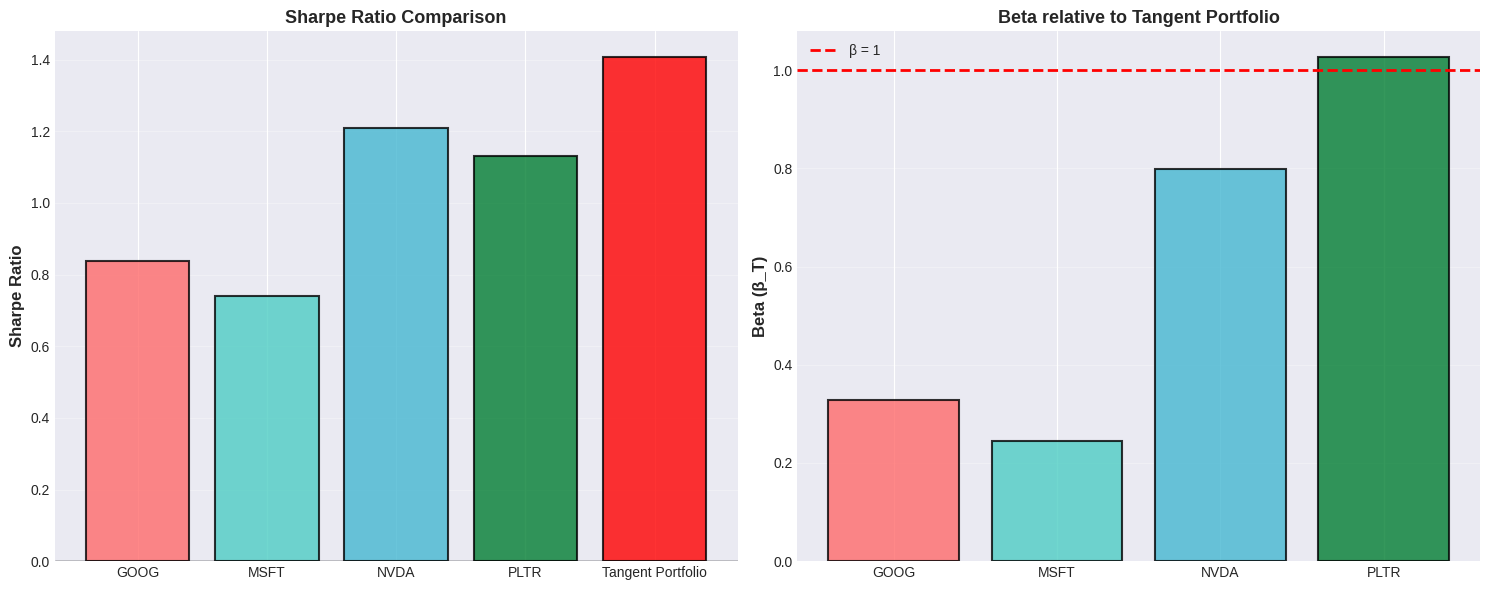

In [42]:
# Calculate performance indicators for each asset
print("=" * 80)
print("PERFORMANCE INDICATORS FOR INDIVIDUAL ASSETS")
print("=" * 80)

# Calculate tangent portfolio variance
var_T = sigma_T ** 2

for i, ticker in enumerate(Tickers):
    print(f"\n{ticker}:")
    print("-" * 40)
    
    # Covariance between asset i and tangent portfolio
    cov_Ti = (Sigma @ pi_T)[i]
    
    # Beta relative to tangent portfolio
    beta_T = cov_Ti / var_T
    
    # Sharpe Ratio
    SR = (M[i] - r0) / STD[i]
    
    # Jensen Index (alpha)
    JI = M[i] - (r0 + beta_T * (m_T - r0))
    
    # Risk decomposition
    systematic_risk = sigma_T * abs(beta_T)
    idiosyncratic_risk = math.sqrt(max(0, STD[i]**2 - sigma_T**2 * beta_T**2))
    
    print(f"  Expected Return:      {M[i]:.4f} ({M[i]*100:.2f}%)")
    print(f"  Volatility:           {STD[i]:.4f} ({STD[i]*100:.2f}%)")
    print(f"  Sharpe Ratio:         {SR:.4f}")
    print(f"  Beta (β_T):           {beta_T:.4f}")
    print(f"  Jensen Index (α):     {JI:.4f} ({JI*100:.2f}%)")
    print(f"  Systematic Risk:      {systematic_risk:.4f} ({systematic_risk*100:.2f}%)")
    print(f"  Idiosyncratic Risk:   {idiosyncratic_risk:.4f} ({idiosyncratic_risk*100:.2f}%)")
    print(f"  Total Risk Check:     {math.sqrt(systematic_risk**2 + idiosyncratic_risk**2):.4f}")

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Sharpe Ratios
sharpe_ratios = [(M[i] - r0) / STD[i] for i in range(n)]
sharpe_ratios.append(SR_T)
labels_sharpe = Tickers + ['Tangent Portfolio']
colors_sharpe = colors_assets + ['red']

axes[0].bar(labels_sharpe, sharpe_ratios, color=colors_sharpe, 
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Sharpe Ratio Comparison', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='black', linewidth=1)

# Plot 2: Beta values
betas = [(Sigma @ pi_T)[i] / var_T for i in range(n)]
axes[1].bar(Tickers, betas, color=colors_assets, 
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Beta (β_T)', fontsize=12, fontweight='bold')
axes[1].set_title('Beta relative to Tangent Portfolio', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=1, color='red', linewidth=2, linestyle='--', label='β = 1')
axes[1].legend()

plt.tight_layout()
plt.show()

## Bonus: Statistical Tests for Normality

We can test if returns follow a normal distribution using the **Jarque-Bera test**:

$$\hat{BJ}(X) = \frac{n}{6}[\hat{Skew}(X)]^2 + \frac{n}{24}[\hat{Kur}(X) - 3]^2 \approx \chi^2(2)$$

Reject normality at level α if $\hat{BJ}(x) > \chi^2_{1-\alpha}(2)$

In [43]:
# Perform Jarque-Bera test for normality
print("=" * 80)
print("JARQUE-BERA TEST FOR NORMALITY")
print("=" * 80)
print("\nH0: Returns are normally distributed")
print("H1: Returns are not normally distributed")
print("Significance level: α = 0.05")
print("\n" + "-" * 80)

alpha = 0.05
chi2_critical = stats.chi2.ppf(1 - alpha, df=2)

for ticker in Tickers:
    returns = data_R[ticker].dropna()
    
    # Calculate skewness and kurtosis
    skewness = stats.skew(returns)
    kurtosis = stats.kurtosis(returns, fisher=True)  # Excess kurtosis
    
    # Jarque-Bera statistic
    n = len(returns)
    JB = (n/6) * skewness**2 + (n/24) * kurtosis**2
    
    # P-value
    p_value = 1 - stats.chi2.cdf(JB, df=2)
    
    # Decision
    reject = "REJECT H0" if JB > chi2_critical else "FAIL TO REJECT H0"
    
    print(f"\n{ticker}:")
    print(f"  Observations (n):     {n}")
    print(f"  Skewness:             {skewness:.4f}")
    print(f"  Excess Kurtosis:      {kurtosis:.4f}")
    print(f"  JB Statistic:         {JB:.4f}")
    print(f"  Critical Value:       {chi2_critical:.4f}")
    print(f"  P-value:              {p_value:.4f}")
    print(f"  Decision:             {reject}")
    
    if p_value < alpha:
        print(f"  → Returns are NOT normally distributed (fat tails or asymmetry)")
    else:
        print(f"  → Returns appear normally distributed")

print("\n" + "=" * 80)
print("Note: Financial returns often exhibit fat tails (leptokurtic distribution)")
print("and asymmetry, violating the normality assumption.")

JARQUE-BERA TEST FOR NORMALITY

H0: Returns are normally distributed
H1: Returns are not normally distributed
Significance level: α = 0.05

--------------------------------------------------------------------------------

GOOG:
  Observations (n):     1255
  Skewness:             0.0622
  Excess Kurtosis:      3.3526
  JB Statistic:         588.5794
  Critical Value:       5.9915
  P-value:              0.0000
  Decision:             REJECT H0
  → Returns are NOT normally distributed (fat tails or asymmetry)

MSFT:
  Observations (n):     1255
  Skewness:             0.1872
  Excess Kurtosis:      3.0743
  JB Statistic:         501.5699
  Critical Value:       5.9915
  P-value:              0.0000
  Decision:             REJECT H0
  → Returns are NOT normally distributed (fat tails or asymmetry)

NVDA:
  Observations (n):     1255
  Skewness:             0.5013
  Excess Kurtosis:      4.4592
  JB Statistic:         1092.3436
  Critical Value:       5.9915
  P-value:              0.0000

## 10. Summary and Key Takeaways

**Portfolio Optimization Results:**

1. **Minimum Variance Portfolio (π_a)**: Provides the lowest possible risk, but may have lower returns

2. **Tangent Portfolio (π_T)**: Maximizes the Sharpe ratio, representing the optimal risky portfolio when combined with a risk-free asset

3. **Efficient Frontier**: Shows all efficient risk-return combinations

4. **Capital Market Line**: The best achievable risk-return tradeoff by combining π_T with the risk-free asset

**Key Insights:**
- The tangent portfolio dominates individual stocks in terms of risk-adjusted returns (Sharpe ratio)
- Diversification reduces risk without necessarily reducing expected returns
- Investors with different risk preferences should all hold the same risky portfolio (π_T) but in different proportions with the risk-free asset (**Two-Fund Separation Theorem**)

# Portfolio Optimization Analysis

## Objective
This notebook demonstrates portfolio optimization using the Markowitz framework for a portfolio of 3 stocks:
- **GOOG** (Google/Alphabet)
- **MSFT** (Microsoft)
- **NVDA** (NVIDIA)
- **PLTR** (Palantir)

We will calculate:
1. Expected returns and volatilities (annualized)
2. Minimum variance portfolio ($\pi_a$)
3. Tangent portfolio ($\pi_T$) with risk-free asset
4. Efficient frontier and Capital Market Line
5. Performance indicators (Sharpe ratio, Beta, Jensen index)